In [309]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import random
import torchvision.transforms as transforms
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
#from google.colab import drive

from torchvision import datasets, transforms


import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [310]:
# # Fully connected neural network with one hidden layer
# class NeuralNet(nn.Module):
#     def __init__(self, input_size, num_classes):
#         super(NeuralNet,self).__init__()
#         self.l1 = nn.Linear(input_size,num_classes)

#     def forward(self,x):
#         out = self.l1(x)
#         # no activation and no softmax at the end
#         return out
    

In [311]:
#input_size = 198*120
#input_size = 11760
#input_size = 7680

# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNet,self).__init__()
        self.l1 = nn.Linear(input_size,160) # first layer
        self.relu = nn.ReLU() # activation function
        self.l2 = nn.Linear(160,num_classes) # second layer

    def forward(self,x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # no activation and no softmax at the end
        return out

In [312]:
# Training function.
def train(epoch, model, loader, criterion, optimizer, device='cpu'):
    l = 0
    for data in tqdm(loader, desc=f'Epoch {epoch+1:03d}'):
        x = data[0].to(device)
        #x = x.view(x.size(0), -1)
        #x = x.view(-1, 198*120)  # flattena le immagini
        y = data[1].squeeze().to(device)
        #print(x.shape)
        out = model(x)
        loss = criterion(out, y) 
        l += loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return l

# # Training function. for AE
# def trainAE(epoch, model, loader, criterion, optimizer, device='cpu')
#     num_epochs = 50
#     for epoch in range(num_epochs):
#         for data in train_loader:
#             img, _ = data
#             img = img.to(device)
#             optimizer.zero_grad()
#             output = model(img)
#             loss = criterion(output, img)
#             loss.backward()
#             optimizer.step()
#         if epoch % 5== 0:
#             print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))


# Test function.
def test(model, loader, criterion, device='cpu'):
    l = 0
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data in loader:
            x = data[0].to(device)
            #x = x.view(-1, 198*120)  # flattena le immagini
            y = data[1].squeeze().to(device)
            out = model(x)
            l += criterion(out, y)
            _, pred = torch.max(out.data, 1)
            total += y.size(0)
            correct += (pred == y).sum().item()
            y_true += y.tolist()
            y_pred += pred.tolist()
    return l, correct / total, y_true, y_pred

In [313]:
# Training function for Linear NN
def trainLinear(epoch, model, loader, criterion, optimizer, device='cpu'):
    l = 0
    for data in tqdm(loader, desc=f'Epoch {epoch+1:03d}'):
        x = data[0].to(device)
        x = x.reshape(-1, 198*120)  # flattena le immagini
        y = data[1].squeeze().to(device)
        #print(x.shape)
        out = model(x)
        loss = criterion(out, y) 
        l += loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return l

# Test function for LinearNN
def testLinear(model, loader, criterion, device='cpu'):
    l = 0
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data in loader:
            x = data[0].to(device)
            x = x.reshape(-1, 198*120)  # flattena le immagini
            y = data[1].squeeze().to(device)
            out = model(x)
            l += criterion(out, y)
            _, pred = torch.max(out.data, 1)
            total += y.size(0)
            correct += (pred == y).sum().item()
            y_true += y.tolist()
            y_pred += pred.tolist()
    return l, correct / total, y_true, y_pred

In [314]:
# Mounta il drive di Google
#drive.mount('/content/drive')

# Definisci le cartelle delle immagini
train_dir = 'Images/train'
test_dir = 'Images/test'

# Definisci le etichette
etichette = ['N', 'A', 'V']

# Crea un dizionario per mappare le etichette ai valori numerici
etichette_map = {etichetta: i for i, etichetta in enumerate(etichette)}

# Funzione per caricare le immagini e le loro etichette
class ImmaginiDataset(torch.utils.data.Dataset):
    def __init__(self, dir, transform=None):
        self.dir = dir
        self.transform = transform
        self.images = []
        for etichetta in etichette:
            path = os.path.join(dir, etichetta)
            for file in os.listdir(path):
                self.images.append((os.path.join(path, file), etichetta))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        path, etichetta = self.images[index]
        #immagine = torchvision.io.read_image(path, mode=torchvision.io.ImageReadMode.LZW)
        immagine = Image.open(path).convert('L') # Converti in bianco e nero
        if self.transform:
            immagine = self.transform(immagine)
        return immagine, etichette_map[etichetta]

# Crea il dataset per l'addestramento
train_dataset = ImmaginiDataset(train_dir)

# Applica le trasformazioni alle immagini
train_transformations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

train_dataset.transform = train_transformations

# Crea il dataset per il test
test_dataset = ImmaginiDataset(test_dir)
test_dataset.transform = train_transformations

# Crea i dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


In [315]:
# Device configuration.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [316]:
# Hyper-parameters.
num_classes = len(etichette)
num_epochs = 5
learning_rate = 0.001

In [317]:
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )
        #Qui devo metterci:
        self.fc = NeuralNet(20 * 11 * 16, num_classes) 
        #se voglio avere modelli confrontabili 
        #self.fc = nn.Linear(20 * 11 * 16, num_classes)

    def forward(self, x):
        #print(f"Input: {x.shape}")
        out = self.layer1(x)
        #print(f"Dopo layer 1: {out.shape}")
        out = self.layer2(out)
        #print(f"Dopo layer 2: {out.shape}")
        out = out.reshape(out.size(0), -1)
        #print(f"Output appiattito: {out.shape}")
        out = self.fc(out)
        #print(f"Output FC: {out.shape}")
        return out


# Create the model.
model = ConvNet(num_classes).to(device)

In [318]:
# Loss and optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training and test._get_conv_output_size
for epoch in range(num_epochs):
    train_loss = train(epoch, model, train_loader, criterion, optimizer, device)
    test_loss, test_acc, y_true, y_pred = test(model, test_loader, criterion, device)
    print(f'Epoch {epoch+1:03d}: training loss {train_loss:.4f}, test loss {test_loss:.4f}, test acc {test_acc:.4f}')

print(classification_report(y_true, y_pred, zero_division=0))

Epoch 001: 100%|██████████| 31/31 [00:08<00:00,  3.55it/s]


Epoch 001: training loss 30.4458, test loss 7.3979, test acc 0.5726


Epoch 002: 100%|██████████| 31/31 [00:08<00:00,  3.59it/s]


Epoch 002: training loss 21.0952, test loss 3.7832, test acc 0.8489


Epoch 003: 100%|██████████| 31/31 [00:07<00:00,  3.90it/s]


Epoch 003: training loss 10.8385, test loss 3.0871, test acc 0.8748


Epoch 004: 100%|██████████| 31/31 [00:07<00:00,  3.98it/s]


Epoch 004: training loss 8.6293, test loss 2.9815, test acc 0.8748


Epoch 005: 100%|██████████| 31/31 [00:07<00:00,  4.01it/s]


Epoch 005: training loss 7.8083, test loss 2.5893, test acc 0.8867
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       288
           1       0.76      0.77      0.77        83
           2       0.96      0.83      0.89       132

    accuracy                           0.89       503
   macro avg       0.87      0.85      0.86       503
weighted avg       0.89      0.89      0.89       503



In [319]:
# Define the autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = nn.functional.interpolate(x, size=(120, 198)) #interpolazione per raggiungere le dimensioni di output
        return x


# Initialize the autoencoder
model = Autoencoder().to(device)

In [320]:
 # Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the autoencoder
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
    #if epoch % 5== 0:
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

# Save the model
torch.save(model.state_dict(), 'conv_autoencoder.pth')

Epoch [1/5], Loss: 0.1296
Epoch [2/5], Loss: 0.0372
Epoch [3/5], Loss: 0.0214
Epoch [4/5], Loss: 0.0152
Epoch [5/5], Loss: 0.0120


<Figure size 1600x1200 with 0 Axes>

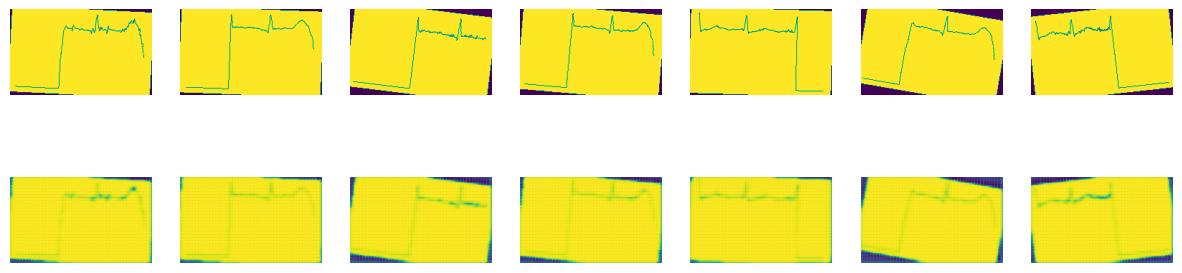

In [321]:
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        recon = model(data)
        break
        
import matplotlib.pyplot as plt
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
for i in range(7):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

In [322]:
import torch
import torch.nn as nn
import os
from PIL import Image
from torchvision import transforms
# Assumiamo che 'device' sia già definito (es. device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
# Assumiamo che 'etichette' e 'etichette_map' siano già definiti come in [1]
# Assumiamo che 'ImmaginiDataset', 'train_transformations', 'train_loader', 'test_loader' siano già definiti come in [2-4]

# Inizializza l'autoencoder e carica il suo stato addestrato [7, 8]
autoencoder_model = Autoencoder().to(device)
autoencoder_model.load_state_dict(torch.load('conv_autoencoder.pth'))
autoencoder_model.eval() # Imposta il modello in modalità valutazione (disabilita dropout/batchnorm se presenti)

# Liste per salvare le feature e le etichette estratte per il training set
latent_features_train = []
labels_train = []

# Estrazione delle feature dal training set
print("Estrazione delle feature dallo spazio latente del training set...")
with torch.no_grad(): # Non calcolare i gradienti per risparmiare memoria e tempo
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        # Estrai le feature utilizzando solo l'encoder dell'Autoencoder [6]
        features = autoencoder_model.encoder(images)
        # Appiattisci le feature per renderle un vettore 1D per ogni immagine [9]
        # La dimensione finale delle feature appiattite dovrebbe essere 8 * 49 * 30 = 11760
        features = features.reshape(features.size(0), -1)
        latent_features_train.append(features.cpu()) # Sposta sulla CPU per concatenazione successiva
        labels_train.append(labels.cpu())

# Concatena tutte le feature e le etichette del training set in un unico tensore
all_latent_features_train = torch.cat(latent_features_train, dim=0)
all_labels_train = torch.cat(labels_train, dim=0)
print(f"Dimensioni totali delle feature latenti (training): {all_latent_features_train.shape}")
print(f"Dimensioni totali delle etichette (training): {all_labels_train.shape}")

# Liste per salvare le feature e le etichette estratte per il test set
latent_features_test = []
labels_test = []

# Estrazione delle feature dal test set
print("Estrazione delle feature dallo spazio latente del test set...")
with torch.no_grad(): # Non calcolare i gradienti per risparmiare memoria e tempo
    for batch_idx, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        # Estrai le feature utilizzando solo l'encoder dell'Autoencoder [6]
        features = autoencoder_model.encoder(images)
        # Appiattisci le feature [9]
        features = features.reshape(features.size(0), -1)
        latent_features_test.append(features.cpu())
        labels_test.append(labels.cpu())

# Concatena tutte le feature e le etichette del test set in un unico tensore
all_latent_features_test = torch.cat(latent_features_test, dim=0)
all_labels_test = torch.cat(labels_test, dim=0)
print(f"Dimensioni totali delle feature latenti (test): {all_latent_features_test.shape}")
print(f"Dimensioni totali delle etichette (test): {all_labels_test.shape}")

# Opzionale: Puoi salvare queste feature e etichette su disco se necessario, ad esempio con torch.save()
# torch.save({'features': all_latent_features_train, 'labels': all_labels_train}, 'latent_features_train.pt')
# torch.save({'features': all_latent_features_test, 'labels': all_labels_test}, 'latent_features_test.pt')

print("Estrazione delle feature completata.")

/tmp/ipykernel_57712/480380103.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder_model.load_state_dict(torch.load('conv_autoencoder.pth'))


Estrazione delle feature dallo spazio latente del training set...
Dimensioni totali delle feature latenti (training): torch.Size([1926, 11760])
Dimensioni totali delle etichette (training): torch.Size([1926])
Estrazione delle feature dallo spazio latente del test set...
Dimensioni totali delle feature latenti (test): torch.Size([503, 11760])
Dimensioni totali delle etichette (test): torch.Size([503])
Estrazione delle feature completata.


In [323]:
# print(all_latent_features_train[400][5444])
# print(all_labels_train)
# print(all_latent_features_test)
# print(all_labels_test)

In [324]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import TensorDataset, DataLoader
# from sklearn.metrics import classification_report, confusion_matrix
# import numpy as np

# # Assumiamo che 'device' sia già definito (es. device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
# # Assumiamo che 'num_classes' sia già definito (es. num_classes = len(etichette) = 3)
# # Assumiamo che 'all_latent_features_train', 'all_labels_train', 'all_latent_features_test', 'all_labels_test'
# # siano stati generati e caricati dal Passo 1

# # Se hai salvato le feature e le etichette nel Passo 1, puoi caricarle qui:
# # data_train = torch.load('latent_features_train.pt')
# # all_latent_features_train = data_train['features']
# # all_labels_train = data_train['labels']
# # data_test = torch.load('latent_features_test.pt')
# # all_latent_features_test = data_test['features']
# # all_labels_test = data_test['labels']

# # 1. Preparazione dei DataLoader per le Feature Latenti [Non specificamente nei sorgenti, ma una conseguenza logica]
# # Crea un dataset personalizzato dalle feature e dalle etichette
# train_latent_dataset = TensorDataset(all_latent_features_train, all_labels_train)
# test_latent_dataset = TensorDataset(all_latent_features_test, all_labels_test)

# # Crea i DataLoader per l'addestramento e il test del classificatore
# # Usiamo un batch_size coerente con quello dei Dataloader originali [1, 2]
# batch_size = 64
# train_latent_loader = DataLoader(dataset=train_latent_dataset, batch_size=batch_size, shuffle=True)
# test_latent_loader = DataLoader(dataset=test_latent_dataset, batch_size=batch_size, shuffle=False)

# # Determina la dimensione dell'input per il classificatore
# # all_latent_features_train.shape[3] sarà la dimensione appiattita (11760 nel tuo caso)
# input_dim_classifier = all_latent_features_train.shape[3]
# print(f"Dimensione delle feature latenti in input al classificatore: {input_dim_classifier}")

# # 2. Definizione del Classificatore [Non specificamente nei sorgenti, ma una conseguenza logica]
# # Useremo una semplice rete neurale feed-forward (MLP)
# class LatentFeatureClassifier(nn.Module):
#     def __init__(self, input_dim, num_classes):
#         super(LatentFeatureClassifier, self).__init__()
#         self.fc1 = nn.Linear(input_dim, 512) # Primo strato lineare
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(0.5) # Aggiungiamo un po' di dropout per prevenire l'overfitting
#         self.fc2 = nn.Linear(512, 256) # Secondo strato lineare
#         self.fc3 = nn.Linear(256, num_classes) # Strato di output con il numero di classi

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.dropout(x)
#         x = self.fc2(x)
#         x = self.relu(x)
#         x = self.fc3(x)
#         return x

# # Inizializza il classificatore
# latent_classifier_model = LatentFeatureClassifier(input_dim_classifier, num_classes).to(device)

# # 3. Definizione della Funzione di Loss e dell'Ottimizzatore [Simile a come fatto per CNN e Autoencoder nei sorgenti: 5, 8]
# criterion_classifier = nn.CrossEntropyLoss() # Per la classificazione multi-classe
# optimizer_classifier = optim.Adam(latent_classifier_model.parameters(), lr=0.001) # Stesso learning rate di base [2, 4]

# # 4. Addestramento del Classificatore [Simile al ciclo di training delle CNN e Autoencoder nei sorgenti: 6, 8]
# num_epochs_classifier = 50 # Potrebbe essere necessario un numero maggiore di epoche per un MLP
# print("\nAddestramento del Classificatore sulle feature latenti...")
# for epoch in range(num_epochs_classifier):
#     latent_classifier_model.train() # Imposta il modello in modalità training
#     running_loss = 0.0
#     for batch_idx, (features, labels) in enumerate(train_latent_loader):
#         features = features.to(device)
#         labels = labels.to(device)

#         # Forward pass
#         outputs = latent_classifier_model(features)
#         loss = criterion_classifier(outputs, labels)

#         # Backward and optimize
#         optimizer_classifier.zero_grad()
#         loss.backward()
#         optimizer_classifier.step()

#         running_loss += loss.item()

#     print(f'Epoch [{epoch+1}/{num_epochs_classifier}], Loss: {running_loss/len(train_latent_loader):.4f}')

# print("Addestramento del classificatore completato.")

# # 5. Valutazione del Classificatore [Simile a come fatto per le CNN nei sorgenti: 6]
# print("\nValutazione del Classificatore sulle feature latenti...")
# latent_classifier_model.eval() # Imposta il modello in modalità valutazione
# y_true_latent = []
# y_pred_latent = []

# with torch.no_grad():
#     correct = 0
#     total = 0
#     for features, labels in test_latent_loader:
#         features = features.to(device)
#         labels = labels.to(device)
#         outputs = latent_classifier_model(features)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#         y_true_latent.extend(labels.cpu().numpy())
#         y_pred_latent.extend(predicted.cpu().numpy())

# accuracy = 100 * correct / total
# print(f'Accuratezza del classificatore sulle feature latenti nel test set: {accuracy:.2f}%')

# # Visualizza il report di classificazione e la matrice di confusione
# print("\nReport di Classificazione:")
# print(classification_report(y_true_latent, y_pred_latent, target_names=['N', 'A', 'V'])) # Utilizza etichette reali [3]
# print("\nMatrice di Confusione:")
# print(confusion_matrix(y_true_latent, y_pred_latent))

# # Opzionale: Salva il modello del classificatore
# # torch.save(latent_classifier_model.state_dict(), 'latent_feature_classifier.pth')

In [325]:
# # 1. Estrarre le feature latenti
# class FeatureExtractor(nn.Module):
#     def __init__(self):
#         super(FeatureExtractor, self).__init__()
#         self.encoder = model.encoder

#     def forward(self, x):
#         return self.encoder(x)

# feature_extractor = FeatureExtractor().to(device)

# class FeatureDataLoader:
#     def __init__(self, data_loader, feature_extractor):
#         self.data_loader = data_loader
#         self.feature_extractor = feature_extractor

#     def __iter__(self):
#         for data, label in self.data_loader:
#             data = data.to(device)
#             feature = self.feature_extractor(data)
#             yield feature, label

# feature_data_loader = FeatureDataLoader(train_loader, feature_extractor)


# # 2. Creare un dataset nuovo
# class LatentFeatureDataset(torch.utils.data.Dataset):
#     def __init__(self, data_loader, feature_extractor):
#         self.data_loader = data_loader
#         self.feature_extractor = feature_extractor
#         self.features = []
#         self.labels = []

#         with torch.no_grad():
#             for data, label in self.data_loader:
#                 data = data.to(device)
#                 feature = self.feature_extractor(data)
#                 self.features.append(feature.cpu().numpy())
#                 self.labels.append(label.cpu().numpy())

#     def __len__(self):
#         return len(self.features)

#     def __getitem__(self, index):
#         return self.features[index], self.labels[index]

# latent_dataset = LatentFeatureDataset(train_loader, feature_extractor)

# # 3. Addestrare la rete densa
# class DenseClassifier(nn.Module):
#     def __init__(self):
#         super(DenseClassifier, self).__init__()
#         self.fc1 = nn.Linear(11760, 128)  # Modifica qui
#         self.relu = nn.ReLU()
#         #self.dropout = nn.Dropout(0.2)
#         self.fc2 = nn.Linear(128, num_classes)

#     def forward(self, x):
#         x = x.view(x.size(0), -1)
#         x = self.relu(self.fc1(x))
#         #x = self.dropout(x)
#         x = self.fc2(x)
#         return x

# dense_classifier = DenseClassifier().to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(dense_classifier.parameters(), lr=learning_rate)

# num_epochs = 5
# for epoch in range(num_epochs):
#     for features, labels in feature_data_loader:
#         features = features.view(features.size(0), -1) # Riduci la dimensionalità di features
#         optimizer.zero_grad()
#         outputs = dense_classifier(features)
#         loss = criterion(outputs, labels.long()) # Aggiungi .long() qui
#         loss.backward()
#         optimizer.step()
#     print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

In [326]:
# # Valutazione sul set di test
# test_feature_data_loader = FeatureDataLoader(test_loader, feature_extractor)

# test_loss = 0
# correct = 0
# total = 0
# num_samples = 0

# with torch.no_grad():
#     for features, labels in test_feature_data_loader:
#         outputs = dense_classifier(features)
#         loss = criterion(outputs, labels.long())
#         test_loss += loss.item() * labels.size(0)
#         _, predicted = torch.max(outputs, 1)
#         correct += (predicted == labels).sum().item()
#         total += labels.size(0)
#         num_samples += labels.size(0)

# accuracy = correct / num_samples
# print(f'Test Loss: {test_loss / num_samples}')
# print(f'Test Accuracy: {accuracy:.4f}')


In [327]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix

# test_labels = []
# test_predicted = []

# with torch.no_grad():
#     for features, labels in test_feature_data_loader:
#         outputs = dense_classifier(features)
#         _, predicted = torch.max(outputs, 1)
#         test_labels.extend(labels.cpu().numpy())
#         test_predicted.extend(predicted.cpu().numpy())

# confusion_matrix = confusion_matrix(test_labels, test_predicted)
# plt.figure(figsize=(10, 8))
# sns.heatmap(confusion_matrix.astype(int), annot=True, cmap='Blues', fmt='d')
# plt.xlabel('Predicted labels')
# plt.ylabel('True labels')
# plt.show()


In [328]:
# test_labels = []
# test_predicted = []

# with torch.no_grad():
#     for features, labels in test_feature_data_loader:
#         outputs = dense_classifier(features)
#         _, predicted = torch.max(outputs, 1)
#         test_labels.extend(labels.cpu().numpy())
#         test_predicted.extend(predicted.cpu().numpy())

# print(classification_report(test_labels, test_predicted, zero_division=0))


In [ ]:
#input_size = 198*120
input_size = 11760
#input_size = 7680

# # Fully connected neural network with one hidden layer
# class NeuralNet(nn.Module):
#     def __init__(self, input_size, num_classes):
#         super(NeuralNet,self).__init__()
#         self.l1 = nn.Linear(input_size,160) # first layer
#         self.relu = nn.ReLU() # activation function
#         self.l2 = nn.Linear(160,num_classes) # second layer

#     def forward(self,x):
#         out = self.l1(x)
#         out = self.relu(out)
#         out = self.l2(out)
#         # no activation and no softmax at the end
#         return out


    
model = NeuralNet(input_size,num_classes).to(device)

In [330]:
print(all_latent_features_train.shape)


torch.Size([1926, 11760])


In [333]:
# Loss and optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training 
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(all_latent_features_train)
    loss = criterion(outputs, all_labels_train)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1:03d}, Loss: {loss.item():.4f}')


model.eval()
with torch.no_grad():
    outputs = model(all_latent_features_test)
    _, predicted = torch.max(outputs, 1)
    y_pred = predicted.cpu().numpy()
    y_true = all_labels_test.cpu().numpy()
    print(classification_report(y_true, y_pred, zero_division=0))

Epoch 001, Loss: 1.3780
Epoch 002, Loss: 21.5014
Epoch 003, Loss: 25.4086
Epoch 004, Loss: 13.3629
Epoch 005, Loss: 12.8270
              precision    recall  f1-score   support

           0       0.57      1.00      0.73       288
           1       0.00      0.00      0.00        83
           2       0.00      0.00      0.00       132

    accuracy                           0.57       503
   macro avg       0.19      0.33      0.24       503
weighted avg       0.33      0.57      0.42       503



In [ ]:
# # Loss and optimizer.
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# # Training and test._get_conv_output_size
# for epoch in range(num_epochs):
#     train_loss = trainLinear(epoch, model, train_loader, criterion, optimizer, device)
#     test_loss, test_acc, y_true, y_pred = testLinear(model, test_loader, criterion, device)
#     print(f'Epoch {epoch+1:03d}: training loss {train_loss:.4f}, test loss {test_loss:.4f}, test acc {test_acc:.4f}')

# print(classification_report(y_true, y_pred, zero_division=0))

In [ ]:
# Loss and optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training and test._get_conv_output_size
for epoch in range(num_epochs):
    train_loss = train(epoch, model, train_loader, criterion, optimizer, device)
    test_loss, test_acc, y_true, y_pred = test(model, test_loader, criterion, device)
    print(f'Epoch {epoch+1:03d}: training loss {train_loss:.4f}, test loss {test_loss:.4f}, test acc {test_acc:.4f}')

print(classification_report(y_true, y_pred, zero_division=0))

Epoch 001: 100%|██████████| 31/31 [00:01<00:00, 27.65it/s]


Epoch 001: training loss 244.9446, test loss 37.7578, test acc 0.5726


Epoch 002: 100%|██████████| 31/31 [00:01<00:00, 29.39it/s]


Epoch 002: training loss 81.5750, test loss 13.4591, test acc 0.2624


Epoch 003: 100%|██████████| 31/31 [00:01<00:00, 30.87it/s]


Epoch 003: training loss 37.8472, test loss 10.0905, test acc 0.5726


Epoch 004: 100%|██████████| 31/31 [00:01<00:00, 29.16it/s]


Epoch 004: training loss 46.4726, test loss 24.0750, test acc 0.2624


Epoch 005: 100%|██████████| 31/31 [00:01<00:00, 29.65it/s]


Epoch 005: training loss 46.1548, test loss 19.4702, test acc 0.5726
              precision    recall  f1-score   support

           0       0.57      1.00      0.73       288
           1       0.00      0.00      0.00        83
           2       0.00      0.00      0.00       132

    accuracy                           0.57       503
   macro avg       0.19      0.33      0.24       503
weighted avg       0.33      0.57      0.42       503

